In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import seaborn as sns
import matplotlib.pyplot as plt

<br>
<font size="4">
O objetivo desse Notebook é criar um modelo de Machine Learning para prever a venda de veículos, baseado no ano do modelo, preço e kilometragem.
</font>

# Passo 1 - Importar o Dataset

In [2]:
dataset = "Dataset/car-prices.csv"
df = pd.read_csv(dataset)
df

,Unnamed: 0,mileage_per_year,model_year,price,sold
0,0,21801,2000,30941.02,yes
1,1,7843,1998,40557.96,yes
2,2,7109,2006,89627.50,no
3,3,26823,2015,95276.14,no
4,4,7935,2014,117384.68,yes
...,...,...,...,...,...
9995,9995,15572,2006,97112.86,no
9996,9996,13246,2002,107424.63,yes
9997,9997,13018,2014,93856.99,no
9998,9998,10464,2011,51250.57,yes


# Passo 2 - Tratamento dos dados

O tratamento será feito na seguinte ordem:
<ul>
    <li>Renomear as colunas do DF para PT-BR, de acordo com a variável map_columns criada abaixo;</li>
    <li>Converter os valores da coluna <b>"vendido"</b> (sim e não) para 0 e 1;</li>
    <li>Criar a coluna idade do modelo, utilizando a coluna <b>"ano_do_modelo"</b> e o ano atual. Para isso é necessário importar a função datetime do módulo datetime, e chamar a função today(), que retorna a data de hoje, e em seguida, usar o atributo year, que corresponde ao ano atual;</li>
    <li>Criar a coluna Km<b>, utilizando a coluna "milhas_por_ano"</b>. Para ter a quilometragem total do veículo, é preciso, primeiramente, converter milhas para quilômetros (taxa de conversão é de 1.60934) e depois multiplicar pelo total de anos do veículo;</li>
    <li>Deletar as colunas que não serão usadas no modelo;</li>
</ul>

In [3]:
map_columns = { 
    'mileage_per_year' : 'milhas_por_ano',
    'model_year' : 'ano_do_modelo',
    'price' : 'preco',
    'sold' :'vendido'
}

map_sold = {
   'yes': 1,
   'no': 0
}

df = df.rename(columns=map_columns)
df.vendido = df.vendido.map(map_sold)
df.head()

,Unnamed: 0,milhas_por_ano,ano_do_modelo,preco,vendido
0,0,21801,2000,30941.02,1
1,1,7843,1998,40557.96,1
2,2,7109,2006,89627.50,0
3,3,26823,2015,95276.14,0
4,4,7935,2014,117384.68,1


In [4]:
ano_atual = datetime.today().year
df['idade_do_modelo'] = ano_atual - df.ano_do_modelo
df.head()

,Unnamed: 0,milhas_por_ano,ano_do_modelo,preco,vendido,idade_do_modelo
0,0,21801,2000,30941.02,1,20
1,1,7843,1998,40557.96,1,22
2,2,7109,2006,89627.50,0,14
3,3,26823,2015,95276.14,0,5
4,4,7935,2014,117384.68,1,6


In [5]:
df['km'] = (df.milhas_por_ano * 1.60934) * df.idade_do_modelo
df.head()

,Unnamed: 0,milhas_por_ano,ano_do_modelo,preco,vendido,idade_do_modelo,km
0,0,21801,2000,30941.02,1,20,701704.42680
1,1,7843,1998,40557.96,1,22,277685.17964
2,2,7109,2006,89627.50,0,14,160171.17284
3,3,26823,2015,95276.14,0,5,215836.63410
4,4,7935,2014,117384.68,1,6,76620.67740


In [6]:
df = df.drop(columns = ["Unnamed: 0", "milhas_por_ano", "ano_do_modelo"], axis=1)
df.head()

,preco,vendido,idade_do_modelo,km
0,30941.02,1,20,701704.42680
1,40557.96,1,22,277685.17964
2,89627.50,0,14,160171.17284
3,95276.14,0,5,215836.63410
4,117384.68,1,6,76620.67740


# Passo 3 - Classificar os dados de treino e teste, treinar os dados e definir um baseline mínimo aceitável do modelo

Primeiramente, é necessário separar o <b>"X"</b> (as colunas que representam as features) e o <b>"Y"</b> (se o carro foi vendido ou não):

In [7]:
x = df[["preco", "idade_do_modelo", "km"]]
y = df["vendido"]

Agora vamos utilizar a função <b>train_test_split()</b> do módulo <b>sklearn</b> para treinar os dados e exibir a quantidade de elementos que foram treinados e testados:

In [8]:
treino_x, teste_x, treino_y, teste_y = train_test_split(x, 
                                                        y, 
                                                        test_size = 0.25,
                                                        stratify = y)
print("O modelo foi treinado com %d elementos e testado com %d elementos" % (len(treino_x), len(teste_x)))

O modelo foi treinado com 7500 elementos e testado com 2500 elementos


<br>
Com o X e o Y de treino e teste definidos, o próximo passo é encontrar um baseline mínimo de reposta que aceitaremos nos modelos.
<br><br>
Para isso, o módulo <b>sklearn</b>, possui um estimador conhecido como <b>DummyClassifier</b>.<br>
Com ele podemos criar um baseline para o nosso modelo, porém, antes precisamos definir qual estratégia será utilizada. Vamos fazer um teste com as 3 estratégias principais para decidir qual usar.

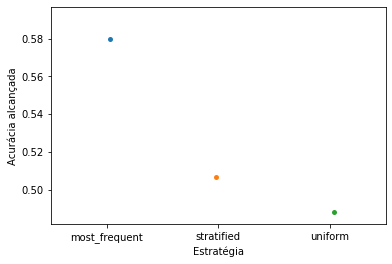

In [9]:
from sklearn.dummy import DummyClassifier

strategias = ['most_frequent', 'stratified', 'uniform']
np.random.seed(30)  # Define o random_statement do algoritmo pelo numpy.

test_scores = [] 
for s in strategias: 
    dummy = DummyClassifier(strategy = s, random_state = 30) 
    dummy.fit(treino_x, treino_y) 
    score = dummy.score(teste_x, teste_y) 
    test_scores.append(score) 

ax = sns.stripplot(strategias, test_scores); 
ax.set(xlabel ='Estratégia', 
       ylabel ='Acurácia alcançada') 
plt.show() 

O gráfico acima mostra o percentual das 3 estratégias escolhidas. Reparem que a estratégia <b>most_frequent</b> se destaca das outras duas, com um valor de proximadamente <b>7</b> pontos percentuais a mais.

Vamos utilizá-la como o baseline!

In [10]:
print("A acurácia do baseline é de %.2f%%" % (test_scores[0] * 100))

A acurácia do baseline é de 58.00%


# Passo 4 - Aplicar os Algoritmos de Machine Learning

In [11]:
modelos = list()
acuracias = list()

Modelo <b>LinearSVC</b>

In [12]:
np.random.seed(30)  # Define o random_statement do algoritmo pelo numpy.

modelo_lsvc = LinearSVC(dual=False)
modelo_lsvc.fit(treino_x, treino_y)
acuracia_lsvc = modelo_lsvc.score(teste_x, teste_y) * 100

modelos.append('LinearSVC')
acuracias.append(acuracia_lsvc)

print("A acurácia do modelo foi de %.2f%%" % acuracia_lsvc)

A acurácia do modelo foi de 58.12%


Modelo <b>KNeighborsClassifier</b>

In [13]:
from sklearn.neighbors import KNeighborsClassifier

modelo_knc = KNeighborsClassifier(n_neighbors = 5) 
modelo_knc.fit(treino_x, treino_y) 
acuracia_knc = modelo_knc.score(teste_x, teste_y) * 100

modelos.append('KNeighborsClassifier')
acuracias.append(acuracia_knc)

print("A acurácia do modelo foi de %.2f%%" % acuracia_knc)

A acurácia do modelo foi de 73.16%


Modelo <b>SVC</b>

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

np.random.seed(30)  # Define o random_statement do algoritmo pelo numpy.

scaler = StandardScaler()
scaler.fit(treino_x)
treino_x_scaled = scaler.transform(treino_x)
teste_x_scaled = scaler.transform(teste_x)

modelo_svc = SVC()
modelo_svc.fit(treino_x_scaled, treino_y)
acuracia_svc = modelo_svc.score(teste_x_scaled, teste_y) * 100

modelos.append('SVC')
acuracias.append(acuracia_svc)

print("A acurácia do modelo foi de %.2f%%" % acuracia_svc)

A acurácia do modelo foi de 76.04%


Modelo <b>DecisionTreeClassifier</b>

In [15]:
from sklearn.tree import DecisionTreeClassifier

np.random.seed(30)  # Define o random_statement do algoritmo pelo numpy.

modelo_dtc = DecisionTreeClassifier(max_depth=3)
modelo_dtc.fit(treino_x, treino_y)
acuracia_dtc = modelo_dtc.score(teste_x, teste_y) * 100

modelos.append('DecisionTreeClassifier')
acuracias.append(acuracia_dtc)

print("A acurácia do modelo foi de %.2f%%" % acuracia_dtc)

A acurácia do modelo foi de 77.16%


Agora vamos verificar o resultado de cada modelo e decidir qual será aplicado nas previsões de venda.

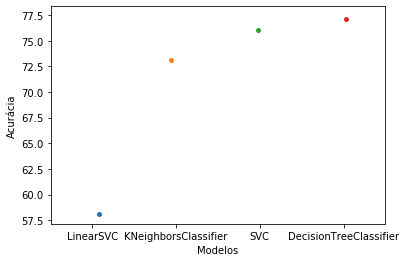

In [16]:
ax = sns.stripplot(modelos, 
                   acuracias); 

ax.set(xlabel ='Modelos', 
       ylabel ='Acurácia') 

plt.show() 

Olhando o gráfico acima, fica fácil escolher o modelo.

A partir de agora, vamos utilizar o <b>DecisionTreeClassifier</b>

# Previsões de Venda

In [17]:
map_previsao = {
    0: 'É provável que esse carro não seja vendido :(',
    1: 'É provável que esse carro seja vendido :)',
}

Valor do Carro: <b>85000</b><br>
Idade do Carro: <b>18 anos</b><br>
Quilometragem: <b>200000</b>

In [18]:
carro = [[85000, 18, 200000]]
previsao_venda = modelo_dtc.predict(carro)
print(map_previsao[previsao_venda[0]])

É provável que esse carro não seja vendido :(


Valor do Carro: <b>35000</b><br>
Idade do Carro: <b>18 anos</b><br>
Quilometragem: <b>200000</b>

In [19]:
carro = [[35000, 18, 200000]]
previsao_venda = modelo_dtc.predict(carro)
print(map_previsao[previsao_venda[0]])

É provável que esse carro seja vendido :)


Valor do Carro: <b>95000</b><br>
Idade do Carro: <b>15 anos</b><br>
Quilometragem: <b>750000</b>

In [20]:
carro = [[95000, 15, 750000]]
previsao_venda = modelo_dtc.predict(carro)
print(map_previsao[previsao_venda[0]])

É provável que esse carro não seja vendido :(


Valor do Carro: <b>23000</b><br>
Idade do Carro: <b>22 anos</b><br>
Quilometragem: <b>990000</b>

In [21]:
carro = [[23000, 22, 990000]]
previsao_venda = modelo_dtc.predict(carro)
print(map_previsao[previsao_venda[0]])

É provável que esse carro seja vendido :)


Vamos fazer diferente agora e perdir que o algoritmo sugira o preço do carro baseado nas colunas <b>vendido</b>, <b>idade_do_modelo</b> e <b>km</b>.

In [22]:
df2 = df.copy()
df2 = df2.astype({'preco': 'int'})
df2.head()

,preco,vendido,idade_do_modelo,km
0,30941,1,20,701704.42680
1,40557,1,22,277685.17964
2,89627,0,14,160171.17284
3,95276,0,5,215836.63410
4,117384,1,6,76620.67740


In [23]:
x2 = df2[["vendido", "idade_do_modelo", "km"]]
y2 = df2["preco"]

In [24]:
np.random.seed(30)
treino_x2, teste_x2, treino_y2, teste_y2 = train_test_split(x2, 
                                                            y2, 
                                                            test_size = 0.25,
                                                            random_state=30,
                                                            stratify = y)

print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x2), len(teste_x)))

Treinaremos com 7500 elementos e testaremos com 2500 elementos


In [25]:
np.random.seed(30)  # Define o random_statement do algoritmo pelo numpy.

modelo_knc2 = DecisionTreeClassifier(max_depth=6) 
modelo_knc2.fit(treino_x2, treino_y2) 

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [26]:
carro = [[1, 22, 988815]]
previsao_venda = modelo_knc2.predict(carro)
print(f"Provavelmente esse carro será vendido com um valor de: {previsao_venda[0]}")

Provavelmente esse carro será vendido com um valor de: 8667


In [27]:
carro = [[1, 11, 450000]]
previsao_venda = modelo_knc2.predict(carro)
print(f"Provavelmente esse carro será vendido com um valor de: {previsao_venda[0]}")

Provavelmente esse carro será vendido com um valor de: 18460


In [28]:
carro = [[1, 6, 196000]]
previsao_venda = modelo_knc2.predict(carro)
print(f"Provavelmente esse carro será vendido com um valor de: {previsao_venda[0]}")

Provavelmente esse carro será vendido com um valor de: 40774


In [29]:
carro = [[1, 4, 56000]]
previsao_venda = modelo_knc2.predict(carro)
print(f"Provavelmente esse carro será vendido com um valor de: {previsao_venda[0]}")

Provavelmente esse carro será vendido com um valor de: 83143


In [30]:
carro = [[1, 1, 5000]]
previsao_venda = modelo_knc2.predict(carro)
print(f"Provavelmente esse carro será vendido com um valor de: {previsao_venda[0]}")

Provavelmente esse carro será vendido com um valor de: 83143


Reparem que nessa abordagem o algoritmo não é tão preciso. Isso acontece por que a base de dados com valores de venda é pequena. Para melhorar o resultado, precisamos de mais dados históricos, porém, a lógica permace sendo a mesma.